In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import haversine as hs
import random
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
seed = 42
random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = xr.open_dataset("../AQ-Experiments/data/delhi_cpcb_2022.nc")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Lalit Chandra Routhu\\iitgn_srip\\Srip-Work-2023\\AQ-Experiments\\data\\delhi_cpcb_2022.nc'

In [ ]:
lat_list =[28.647622, 28.710508, 28.6514781, 28.7256504, 28.656756, 28.815329, 28.531346, 28.639645, 28.623763, 28.58028, 28.6811736, 28.695381, 28.5710274, 28.5504249, 28.7500499, 28.563262, 28.5512005, 28.639645, 28.530785, 28.570173, 28.822836, 28.60909, 28.732528, 28.7762, 28.6573814, 28.672342, 28.5918245, 28.636429, 28.5627763, 28.4706914, 28.498571, 28.628624, 28.73282, 28.56789, 28.699793, 28.674045, 28.684678, 28.611281, 28.588333]

In [ ]:
df_ = data.to_dataframe().reset_index()

df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=['PM2.5'])
le = LabelEncoder()
df['station_le'] = le.fit_transform(df['station'])

In [4]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude,station_le
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.0,3.78,43.38,26.15,3.42,...,NaN,139.97,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010,0
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.0,11.88,30.62,26.02,15.82,...,0.30,246.25,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809,1
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.0,7.47,67.17,41.80,50.77,...,0.38,206.90,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665,2
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.3,22.49,26.28,48.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936,3
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.0,4.80,20.65,25.43,41.45,...,0.62,22.33,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074,4


In [5]:
df['pm_cat'] = pd.qcut(df['PM2.5'], q = 10, labels = [0,1,2,3,4,5,6,7,8,9])
df['pm_cat'].value_counts()

pm_cat
0    4
1    4
2    4
3    4
4    4
6    4
7    4
8    4
9    4
5    3
Name: count, dtype: int64

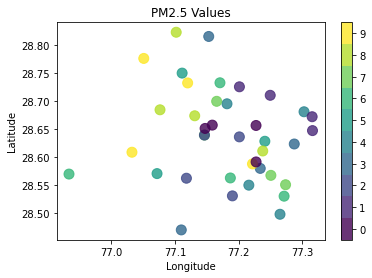

In [6]:
plt.scatter(df['longitude'], df['latitude'], c = df['pm_cat'], s = 100, alpha = 0.8)
plt.colorbar(ticks = [0,1,2,3,4,5,6,7,8,9], boundaries = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('PM2.5 Values');

In [7]:
station = {}
lat = []
long = []
for i in df.station_le.unique():
    lat_i = df[df['station_le'] == i]['latitude'].item()
    long_i = df[df['station_le'] == i]['longitude'].item()
    pm_i = df[df['station_le'] == i]['pm_cat'].item()
    s_name = df[df['station_le'] == i]['station'].item()
    
    
    station[i] = [lat_i, long_i, pm_i,s_name]
    long.append(long_i)
    lat.append(lat_i)

In [8]:
def get_distance(lat1, lon1, lat2, lon2):
    # Calculate the distance between the coordinates using the Haversine formula
    return hs.haversine((lat1, lon1), (lat2, lon2))

distances = [] #Store distance between each pair of nodes
for i in station.keys():
    temp = []
    for j in station.keys():
        if i==j:
            continue
        else:
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
    distances.append(temp)

In [9]:
for i in range(len(distances)):
    distances[i].sort()

In [10]:
import networkx as nx

no_of_neighbours = 7

G = nx.Graph()

for i in station.keys():
    G.add_node(i, latitude = station[i][0], longitude = station[i][1], pm = station[i][2], station = station[i][3])
    
    for j in range(no_of_neighbours): #Add edge connecting nodes closest to current node
        s = distances[i][j][1]
        G.add_node(s, latitude = station[s][0], longitude = station[s][1], pm = station[s][2])
        G.add_edge(i, s)


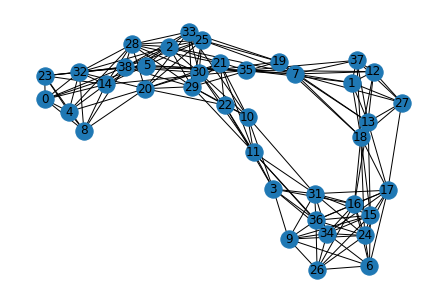

In [11]:
layout1 = nx.spring_layout(G, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
nx.draw(G, pos=layout1, with_labels=True)
plt.show()

In [12]:
node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.int64).view(-1, 1)

In [13]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 10)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.sin(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = torch.sin(x)
        x = self.linear2(x)
        x = F.softmax(x, dim=1)
        return x

In [14]:
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G.nodes):
    lat = G.nodes[node]['latitude']
    if lat in lat_list[:25]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

In [15]:
X_train = data1.x[data1.train_mask].numpy()
y_train = data1.y[data1.train_mask].numpy().reshape(-1)
X_test = data1.x[data1.test_mask].numpy()
y_test = data1.y[data1.test_mask].numpy().reshape(-1)

In [16]:
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = ClassificationModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:
losses = []

from tqdm import tqdm

#Training Loop for Graph
for epoch in tqdm(range(2300)):
    optimizer.zero_grad()
    out = model1(data1.x.to(device), data1.edge_index.to(device))
    loss = criterion(out[data1.train_mask].squeeze(), data1.y[data1.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████| 2300/2300 [00:10<00:00, 213.07it/s]


In [18]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(n_neighbors = 8),
    SVC(kernel = 'linear'),
    SVC(kernel = 'rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=1000, random_state=42),
    AdaBoostClassifier(),
    GaussianNB()]

# tabulate results
results = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    f1 = f1_score(y_test, clf.predict(X_test), average='weighted')
    pre = precision_score(y_test, clf.predict(X_test), average='weighted')
    rec = recall_score(y_test, clf.predict(X_test), average='weighted')
    results.append([name, score, f1, pre, rec])


# Add XGBoost
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3)
xgb_model.fit(X_train, y_train)

score = xgb_model.score(X_test, y_test)
f1 = f1_score(y_test, xgb_model.predict(X_test), average='weighted')
pre = precision_score(y_test, xgb_model.predict(X_test), average='weighted')
rec = recall_score(y_test, xgb_model.predict(X_test), average='weighted')

results.append(['XGBoost', score, f1, pre, rec])

# Add Neural Network
# f1 = f1_score(y_test_torch, net(X_test_torch).argmax(1), average='weighted')
# pre = precision_score(y_test_torch, net(X_test_torch).argmax(1), average='weighted')
# rec = recall_score(y_test_torch, net(X_test_torch).argmax(1), average='weighted')

# results.append([f'Neural Network | Epochs = {epochs}', net(X_test_torch).argmax(1).eq(y_test_torch).sum().item()/len(y_test_torch), f1, pre, rec])

# Add bagging classifier
# f1 = f1_score(y_test_torch, predictions, average='weighted')
# pre = precision_score(y_test_torch, predictions, average='weighted')
# rec = recall_score(y_test_torch, predictions, average='weighted')

# results.append([f'Neural Network w/ Boostrapping | Epochs = {num_epochs}', accuracy, f1, pre, rec])

# Add Gaussian Process
# gpc = GaussianProcessClassifier()
# gpc.fit(X_train_torch, y_train_torch)
# score = gpc.score(X_test, y_test)
# f1 = f1_score(y_test, gpc.predict(X_test), average='weighted')
# pre = precision_score(y_test, gpc.predict(X_test), average='weighted')
# rec = recall_score(y_test, gpc.predict(X_test), average='weighted')

# results.append(['Gaussian Process Classifier', score, f1, pre, rec])

# make tabulate prettier
print(tabulate(results, headers=['Classifier', 'Accuracy', 'F1', 'Precision', 'Recall'], tablefmt='fancy_grid'), sep='\n', end='\n')

C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

╒═══════════════════╤════════════╤═══════════╤═════════════╤═══════════╕
│ Classifier        │   Accuracy │        F1 │   Precision │    Recall │
╞═══════════════════╪════════════╪═══════════╪═════════════╪═══════════╡
│ Nearest Neighbors │  0.142857  │ 0.142857  │   0.178571  │ 0.142857  │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┤
│ Linear SVM        │  0.142857  │ 0.0918367 │   0.0833333 │ 0.142857  │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┤
│ RBF SVM           │  0.142857  │ 0.0952381 │   0.0857143 │ 0.142857  │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┤
│ Decision Tree     │  0.0714286 │ 0.0952381 │   0.142857  │ 0.0714286 │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┤
│ Random Forest     │  0.0714286 │ 0.0952381 │   0.142857  │ 0.0714286 │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┤
│ AdaBoost          │  0         │ 0         │   0 

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
df = data.to_dataframe()
# df = df["2022-01-01": "2022-12-31"]
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])

delhi_shapefile = gpd.read_file('data/Delhi/Districts.shp')
gdf_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

latitudes = np.array(df['latitude'])
longitudes = np.array(df['longitude'])

g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)

lat_grid, lon_grid = np.meshgrid(g_lat, g_long)
temp_data = gpd.GeoDataFrame(geometry = gpd.points_from_xy(lon_grid.flatten(), lat_grid.flatten()))

def plot_heatmap(lat, lon, values): #lat, lon, values are numpy arrays

    delhi_shapefile = gpd.read_file('data/Delhi/Districts.shp')

    shapefile_extent = delhi_shapefile.total_bounds

    fig, ax = plt.subplots(figsize=(10, 10))

#     plt.xlim(shapefile_extent[0], shapefile_extent[2])
#     plt.ylim(shapefile_extent[1], shapefile_extent[3])
    
    contour = ax.contourf(lon.reshape(lon_grid.shape), lat.reshape(lon_grid.shape), values.reshape(lon_grid.shape), cmap = 'coolwarm')

    # Add the shapefile to the plot
    delhi_shapefile.plot(ax=ax, edgecolor='black', facecolor='none')

    gdf_data.plot(ax=ax, color='black', markersize=20, label='Air Stations')
#     temp_data.plot(ax=ax, color='black', markersize=20, label='Predicted Points')

    # Add a colorbar
    plt.colorbar(contour,ticks = [0,1,2,3,4,5,6,7,8,9], boundaries = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], shrink = 0.7)

    # Customize the plot appearance
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('PM2.5 Predictions Heatmap')
    plt.legend()
    plt.show()

In [21]:
latitudes = np.array(df['latitude'])
longitudes = np.array(df['longitude'])
g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
lat_grid, lon_grid = np.meshgrid(g_lat, g_long)

train = df[['latitude', 'longitude', 'PM2.5']]
test_stats = [i for i in range(len(lon_grid.flatten()))]
test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten(),
                     'station':test_stats})

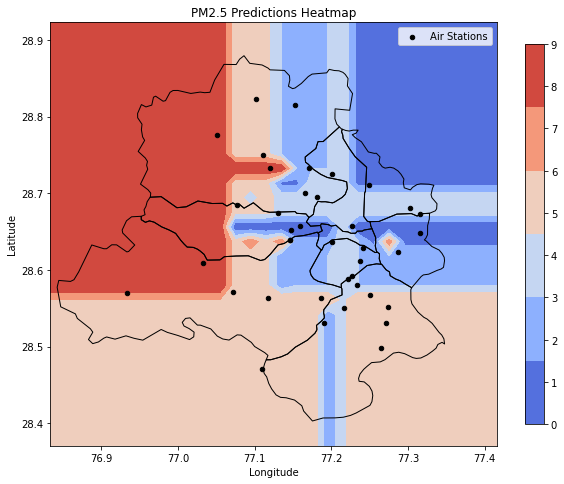

In [22]:
X_test = test[['latitude', 'longitude']]
test['KNN'] = xgb_model.predict(X_test)
plot_heatmap(np.array(test['latitude']), np.array(test['longitude']), np.array(test['KNN']))

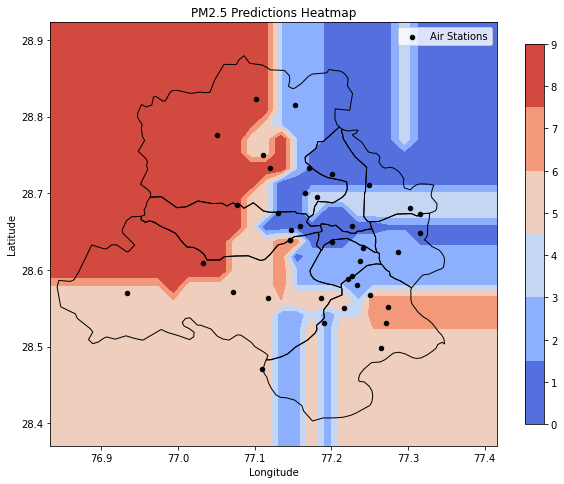

In [23]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
X_test = test[['latitude', 'longitude']]
test['RF'] = rf_model.predict(X_test)
plot_heatmap(np.array(test['latitude']), np.array(test['longitude']), np.array(test['RF']))

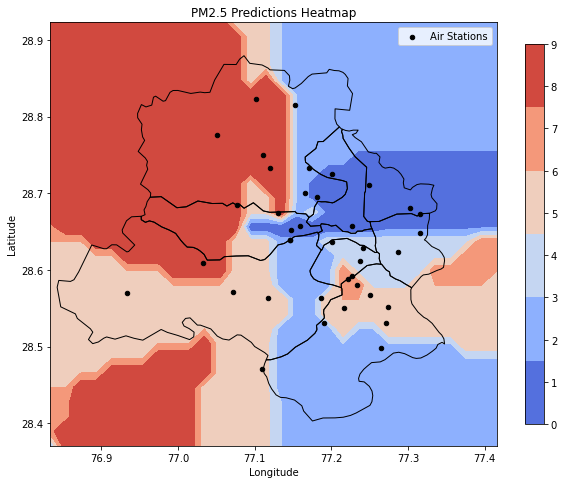

In [24]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
X_test = test[['latitude', 'longitude']]
test['NB'] = naive_bayes.predict(X_test)
plot_heatmap(np.array(test['latitude']), np.array(test['longitude']), np.array(test['NB']))